# Tutorial3: Estimating accretion angles from video pixels
---
This tutorial demonstrates estimation of accretion angles from video pixels. By utilizing modes of the underlying SPDE a loss manifold is computed and the underlying accretion parameters are estimated as a global minimum to a loss function.

Computing mode dataset
---
This tutorial assumes that a dataset of modes was previously computed. The dataset can be computed using
```
compute_modes_dataset.py --config configs/opening_angles.yaml
```
This script is time-consuming. Altenratively, [download a precomputed mode dataset](https://caltech.box.com/s/yqnzqs7gpeia9kwrf48zfmm2vy8by5lo).  

For information about the dataset parameters see the input configuration file `configs/opening_angles.yaml` and command line arguments `python scripts/compute_modes_dataset.py --h`. For a tutorial overview of the random subspace iteration (RSI) mode computation see `Tutorial2`.

In [1]:
%matplotlib notebook
import pynoisy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

Welcome to eht-imaging! v 1.1.1 



In [2]:
"""
Define a Solver object as the foward operator and sample a GRF with random true underlying parameters
"""
true_params = {'temporal_angle': 2 * np.pi * np.random.rand() - np.pi,
               'spatial_angle': np.pi * np.random.rand() - np.pi/2}
diffusion = pynoisy.diffusion.general_xy(nx=64, ny=64, opening_angle=true_params['spatial_angle'])
advection = pynoisy.advection.general_xy(nx=64, ny=64, opening_angle=true_params['temporal_angle'])
solver = pynoisy.forward.HGRFSolver(advection, diffusion, nt=64)
measurements = solver.run()

<IPython.core.display.Javascript object>


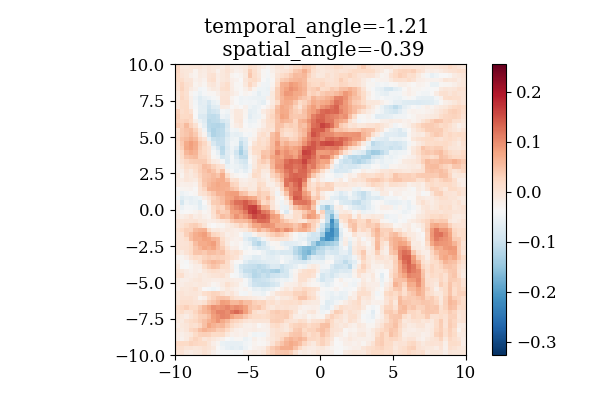

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title('temporal_angle={:1.2f} \n spatial_angle={:1.2f}'.format(
    true_params['temporal_angle'], true_params['spatial_angle']))
plt.tight_layout()
measurements.utils_visualization.animate(ax=ax)

In [28]:
"""
Load multi-file dataset with xarray and dask for parallel computations.
Replace `mode_directory` with the current directory of the modes
"""
mode_directory = '../datasets/opening_angles.09-Apr-2021-18:48:05/modes/'
modes = xr.open_mfdataset(os.path.join(mode_directory, 'mode*.nc'))
subspace = modes.eigenvectors * modes.eigenvalues
subspace

,Array,Chunk
Bytes,50.33 GB,125.83 MB
Shape,"(20, 20, 60, 64, 64, 64)","(1, 1, 60, 64, 64, 64)"
Count,4400 Tasks,400 Chunks
Type,float64,numpy.ndarray


In [29]:
"""
Compute the 2D loss manifold, note this may take a while and take up resources. 
Takes ~5 minutes for 60 modes of size 64x64x64 with 24 CPU cores.
"""
dataset = pynoisy.inverse.compute_pixel_loss(subspace, measurements)

[########################################] | 100% Completed |  5min 49.0s


<IPython.core.display.Javascript object>


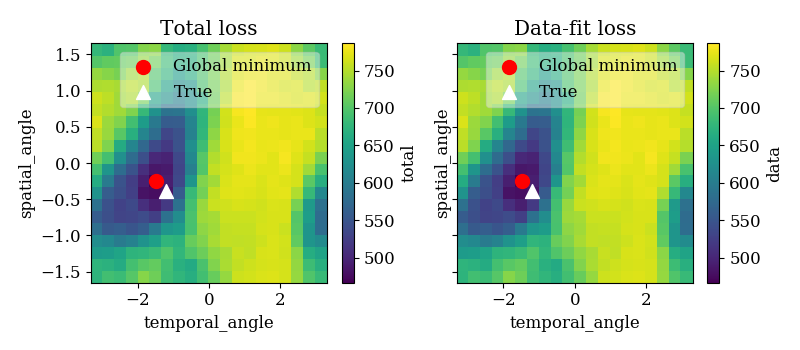

In [30]:
"""
Visualize the data-fit manifolds and true parameters
"""
fig, axes = plt.subplots(1,2, figsize=(8,3.5), sharey=True)
dataset.total.utils_loss.plot2d(ax=axes[0], true=true_params)
dataset.data.utils_loss.plot2d(ax=axes[1], true=true_params)
axes[0].set_title('Total loss')
axes[1].set_title('Data-fit loss');

In [31]:
"""
Generate a solver from the estimated parameters (minimum point of the total loss)
"""
minimum = dataset.total.utils_loss.argmin()
diffusion_estimated = pynoisy.diffusion.general_xy(nx=64, ny=64, opening_angle=minimum['spatial_angle'])
advection_estimated = pynoisy.advection.general_xy(nx=64, ny=64, opening_angle=minimum['temporal_angle'])
solver_estimated = pynoisy.forward.HGRFSolver(advection_estimated, diffusion_estimated, nt=64)
grf_estimated_params = solver_estimated.run()

<IPython.core.display.Javascript object>


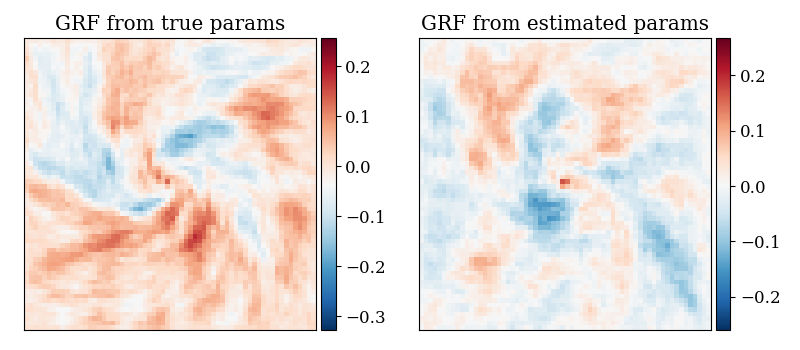

In [32]:
fig, axes = plt.subplots(1,2, figsize=(8, 3.5), sharey=True)
movie_list = [measurements, grf_estimated_params]
titles = ['GRF from true params', 'GRF from estimated params']
pynoisy.visualization.animate_synced(movie_list, axes, titles=titles)